# Machine learning

In [1]:
import pandas as pd
import numpy as np
import pickle
from time import time
import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Import the data 

In [2]:
df_pc = pd.read_pickle('pc_processed.pkl')
df_total = pd.read_pickle('total_processed.pkl')

In [3]:
df_pc.head()

,champID,maxNumDeaths,mostChampionKillsPerSession,league,champ1R,champ2R,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
summID,,,,,,,,,,,,,,,,,,
43878231,222,15,29,4,3,3,13289.050314,183.358491,168059.830189,10656.628931,21485.754717,1.207547,0.257862,0.069182,0.006289,1.905660,2.517906,0.503145
58082410,98,13,13,0,5,5,10635.666667,83.491228,29416.666667,51620.842105,30960.789474,0.228070,0.035088,0.000000,0.000000,0.473684,3.299383,0.508772
20417927,245,12,18,1,0,0,11677.828125,141.046875,21758.843750,108591.515625,23959.375000,0.781250,0.203125,0.015625,0.000000,0.765625,3.530405,0.515625
52542846,107,13,27,1,0,0,13386.260870,107.608696,148456.556522,17242.860870,26378.391304,1.460870,0.286957,0.034783,0.008696,0.982609,2.815493,0.660870
30131741,12,10,6,4,5,5,8388.423077,43.442308,8550.884615,14487.326923,23275.153846,0.000000,0.000000,0.000000,0.000000,0.326923,4.181818,0.596154


In [4]:
df_total.head()

,league,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,Heal,NeutralMinionsKilled,totalKDA,WinRate
summID,,,,,,,,,,,,,,,
43878231,4,11542.636731,114.821197,82212.913430,32395.096278,25731.042071,0.664239,0.103560,0.018608,0.002427,0.985437,3320.345469,22.512136,2.586861,0.503145
58082410,0,11413.241546,79.270531,60077.579710,42597.009662,30861.487923,0.338164,0.024155,0.000000,0.000000,0.579710,4841.830918,24.724638,2.491701,0.508772
20417927,1,11986.011168,153.420305,79579.971574,57813.944162,23811.927919,0.684264,0.096447,0.019289,0.001015,1.110660,3755.418274,19.312690,2.872486,0.515625
52542846,1,13221.147705,135.826347,127510.532934,29848.522954,28104.948104,1.273453,0.281437,0.059880,0.015968,1.391218,4067.017964,36.425150,2.671528,0.660870
30131741,4,10312.076037,62.435484,34599.866359,42007.988479,24071.145161,0.239631,0.025346,0.006912,0.000000,0.603687,4704.658986,26.470046,3.009035,0.596154


In [5]:
y_pc = df_pc['league'].values
X_pc = df = df_pc.drop('league', 1)

In [6]:
y_total = df_pc['league'].values
X_total = df = df_pc.drop('league', 1)

## Data split and feature engineering

In [7]:
X_pc = X_pc[['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned', 'MinionKills',
      'PhysicalDamageDealt', 'MagicDamageDealt', 'DamageTaken', 'DoubleKills', 'TripleKills',
       'QuadraKills', 'PentaKills', 'TurretsKilled', 'KDA', 'WinRate']]
X_total = X_total[['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned', 'MinionKills',
      'PhysicalDamageDealt', 'MagicDamageDealt', 'DamageTaken', 'DoubleKills', 'TripleKills',
       'QuadraKills', 'PentaKills', 'TurretsKilled', 'KDA', 'WinRate']]

In [8]:
X_n = preprocessing.normalize(preprocessing.scale(X_pc))

### Univariate Feature Selection

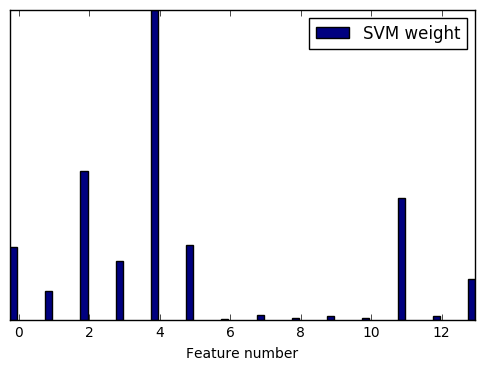

In [15]:
clf = SVC(kernel='linear')
clf.fit(X_n, y_pc)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

X_indices = np.arange(X_pc.shape[-1])

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy')

plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

### Recursive Feature Elimination (RFE)

In [25]:
estimator = SVC(kernel="linear")
for i in range(4,10,1):
    selector = RFE(estimator, i, step=1)
    selector = selector.fit(X_n, y_pc)
    feature_selection = selector.support_ 
    print(i,"features Selection by RFE are:\n", X_pc.columns[feature_selection])

4 features Selection by RFE are:
 Index(['maxNumDeaths', 'GoldEarned', 'PhysicalDamageDealt',
       'MagicDamageDealt'],
      dtype='object')
5 features Selection by RFE are:
 Index(['maxNumDeaths', 'GoldEarned', 'PhysicalDamageDealt', 'MagicDamageDealt',
       'TurretsKilled'],
      dtype='object')
6 features Selection by RFE are:
 Index(['maxNumDeaths', 'GoldEarned', 'MinionKills', 'PhysicalDamageDealt',
       'MagicDamageDealt', 'TurretsKilled'],
      dtype='object')
7 features Selection by RFE are:
 Index(['maxNumDeaths', 'GoldEarned', 'MinionKills', 'PhysicalDamageDealt',
       'MagicDamageDealt', 'TurretsKilled', 'WinRate'],
      dtype='object')
8 features Selection by RFE are:
 Index(['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned',
       'MinionKills', 'PhysicalDamageDealt', 'MagicDamageDealt',
       'TurretsKilled', 'WinRate'],
      dtype='object')
9 features Selection by RFE are:
 Index(['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned',
     

### Feature importances with trees

#### Raw data

Feature ranking:
1. feature 3 (0.100627)
2. feature 0 (0.079054)
3. feature 4 (0.077993)
4. feature 2 (0.077106)
5. feature 13 (0.076833)
6. feature 5 (0.075715)
7. feature 6 (0.074853)
8. feature 11 (0.074818)
9. feature 12 (0.074422)
10. feature 1 (0.073794)
11. feature 7 (0.071756)
12. feature 8 (0.063063)
13. feature 9 (0.049735)
14. feature 10 (0.030233)


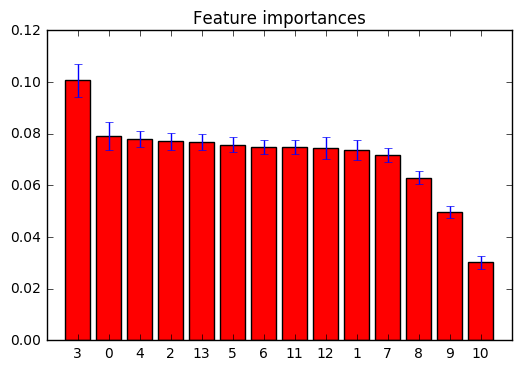

In [24]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_pc, y_pc)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_pc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_pc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_pc.shape[1]), indices)
plt.xlim([-1, X_pc.shape[1]])
plt.show()

#### Scale data

Feature ranking:
1. feature 3 (0.100567)
2. feature 0 (0.079076)
3. feature 4 (0.077968)
4. feature 2 (0.077159)
5. feature 13 (0.076823)
6. feature 5 (0.075689)
7. feature 6 (0.074878)
8. feature 11 (0.074812)
9. feature 12 (0.074429)
10. feature 1 (0.073751)
11. feature 7 (0.071771)
12. feature 8 (0.063076)
13. feature 9 (0.049752)
14. feature 10 (0.030250)


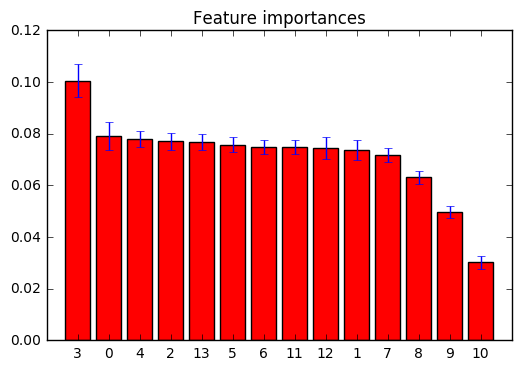

In [23]:
X_s =preprocessing.scale(X_pc)
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_s, y_pc)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_s.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_s.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_s.shape[1]), indices)
plt.xlim([-1, X_s.shape[1]])
plt.show()

#### Normalize and Scale data

Feature ranking:
1. feature 3 (0.092797)
2. feature 0 (0.088665)
3. feature 1 (0.073176)
4. feature 13 (0.072284)
5. feature 12 (0.069663)
6. feature 2 (0.069467)
7. feature 6 (0.068720)
8. feature 4 (0.068649)
9. feature 5 (0.068575)
10. feature 11 (0.068390)
11. feature 7 (0.066614)
12. feature 10 (0.064526)
13. feature 9 (0.064258)
14. feature 8 (0.064214)


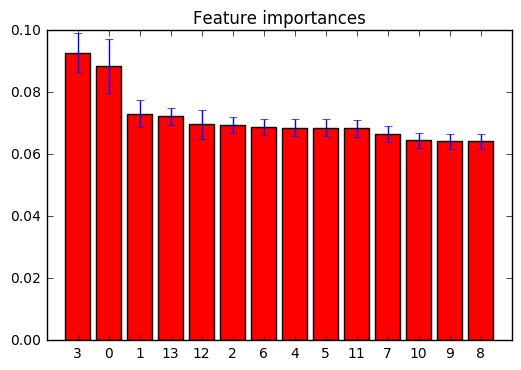

In [21]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_n, y_pc)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_n.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_n.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_n.shape[1]), indices)
plt.xlim([-1, X_n.shape[1]])
plt.show()

# Unsupervised Clustering

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

## K-means

Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [ ]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [ ]:
labels = y_total
n_samples, n_features = X_total.shape
sample_size = n_samples
bench_k_means(KMeans(init='k-means++', n_clusters=5, n_init=10), name="k-means++", data=X_pc)

In [ ]:
k_means = KMeans(init='k-means++', n_clusters=5, n_init=10)
k_means.fit(X_pc_tr)

## GMM

Source: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html

In [ ]:
from sklearn import mixture
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

In [ ]:
X = X_total[['GoldEarned', 'MinionKills', 'KDA']]

In [ ]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold','darkorange'])
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

# Supervised classification (predicting the elo)

## SVC

In [26]:
X_pc = X_pc[['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned', 'MinionKills',
      'PhysicalDamageDealt', 'MagicDamageDealt', 'DamageTaken', 'DoubleKills', 'TripleKills',
       'QuadraKills', 'PentaKills', 'TurretsKilled', 'KDA', 'WinRate']]

In [27]:
pca = PCA()
X_n = pca.fit_transform(preprocessing.scale(X_pc))

In [28]:
clf = SVC(kernel='linear')
values = cross_val_score(clf, X_n, y_pc, cv=10)
print('Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))

Mean Accuracy : 0.393890609328 	STD:  0.00582715103927


In [29]:
clf = SVC(kernel='rbf')
values = cross_val_score(clf, X_n, y_pc, cv=10)
print('Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))

Mean Accuracy : 0.422845528182 	STD:  0.00914086188424


In [32]:
X_tr, X_te, y_tr, y_te = train_test_split(X_n, y_pc, test_size=0.4, random_state=0)

## NO TOCAR LAS 2 SIGUIENTES CELDAS

Mirar class_weight_range ["auto", "balanced"] #Balanced puede haver problema con master :D

In [19]:
C_range = 10.0 ** np.arange(-4, 4)
gamma_range = 10.0 ** np.arange(-4, 4)
param_grid = {"gamma": gamma_range.tolist(), "C": C_range.tolist()}

In [20]:
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, n_jobs = -1)
grid.fit(X_tr, y_tr)
print("The best classifier is: ", grid.best_estimator_)

The best classifier is:  SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [30]:
clf = SVC(C=1000.0, gamma=0.01, kernel='rbf')
values = cross_val_score(clf, X_n, y_pc, cv=10)
print('Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))

Mean Accuracy : 0.439152879246 	STD:  0.00930493367288


In [33]:
clf.fit(X_tr, y_tr)
clf.score(X_te, y_te)

0.4416204360727648

In [34]:
y_hat = clf.predict(X_te)
cnf_matrix = confusion_matrix(y_te, y_hat)

In [35]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

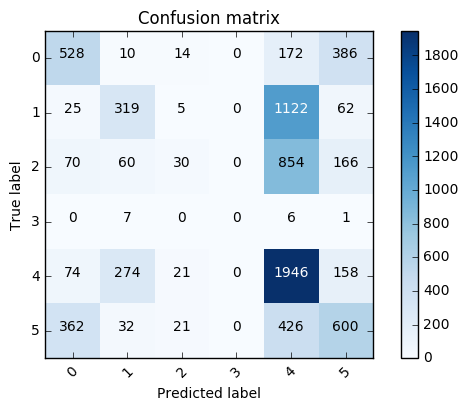

In [36]:
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_pc))

In [37]:
print("Accuracy: ", sum(cnf_matrix.diagonal())/sum(sum(cnf_matrix)))

Accuracy:  0.441620436073


### Multi BinariSVM Classifier

In [38]:
def select_data():
    data_set = pd.read_pickle('pc_processed.pkl')
    y_ds = data_set['league'].values
    x_ds = data_set.drop('league', 1)
    return x_ds[['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned', 'MinionKills',
      'PhysicalDamageDealt', 'MagicDamageDealt', 'DamageTaken', 'DoubleKills', 'TripleKills',
       'QuadraKills', 'PentaKills', 'TurretsKilled', 'KDA', 'WinRate']], y_ds

In [39]:
accuracy = []
x_ds, y_ds = select_data()
pca = PCA()
X_ds = pca.fit_transform(preprocessing.scale(x_ds))
for first in np.unique(y_ds):
    for second in np.unique(y_ds):
        if first < second:
            y_ = np.logical_or(y_ds == first, y_ds == second)
            y_subset = y_ds[y_]
            x_subset = x_ds[y_.transpose()]
            clf = SVC(kernel='rbf')            
            values = cross_val_score(clf, x_subset, y_subset, cv=10)
            print('Class: ', first, " VS ", second,' Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))
            accuracy.append(np.mean(values))            
print("Mean acc:", sum(accuracy)/len(accuracy))     

Class:  0  VS  1  Mean Accuracy : 0.578235559593 	STD:  0.000259534809811
Class:  0  VS  2  Mean Accuracy : 0.509697780603 	STD:  0.000264337915221
Class:  0  VS  3  Mean Accuracy : 0.990123390772 	STD:  0.00139228037819
Class:  0  VS  4  Mean Accuracy : 0.685320364917 	STD:  0.000362418784677
Class:  0  VS  5  Mean Accuracy : 0.566507193548 	STD:  0.000258913531678
Class:  1  VS  2  Mean Accuracy : 0.56874643033 	STD:  9.32610185745e-05
Class:  1  VS  3  Mean Accuracy : 0.992776165637 	STD:  0.00102126070637
Class:  1  VS  4  Mean Accuracy : 0.613677547142 	STD:  0.000281089083099
Class:  1  VS  5  Mean Accuracy : 0.511977659574 	STD:  1.46252415796e-05
Class:  2  VS  3  Mean Accuracy : 0.990495760056 	STD:  0.00133918977715
Class:  2  VS  4  Mean Accuracy : 0.676894259095 	STD:  0.00033702743331
Class:  2  VS  5  Mean Accuracy : 0.556956368096 	STD:  7.93816508851e-05
Class:  3  VS  4  Mean Accuracy : 0.995439471134 	STD:  0.000648947317901
Class:  3  VS  5  Mean Accuracy : 0.9924243

In [40]:
X_ds = pca.fit_transform(preprocessing.scale(x_ds))
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=0.40, random_state=42)
classifiers = []
name_classifier = []
for first in np.unique(y_ds):
        for second in np.unique(y_ds):
            if first < second:
                y_ = np.logical_or(y_train == first, y_train == second)
                y_subset = y_train[y_]
                x_subset = X_train[y_.transpose()]
                clf = SVC(kernel='rbf', probability = True)
                clf.fit(x_subset, y_subset)
                classifiers.append(clf)
                name_classifier.append( [first,second] )

results = []
itr = 0
for clf in classifiers:
    predictions = clf.predict_proba(X_test)
    classifier = name_classifier[itr]
    results.append([ [classifier[np.argmax(prediction)], np.amax(prediction)] 
                    for prediction in predictions ]
                  )
    itr+=1
    

In [41]:
prediction = []
for i in range(0,len(results[0])):
    temp_clas = results[0][i][0]
    temp_prob = results[0][i][1]
    for j in range(1,len(results)):
        if temp_prob < results[j][i][1]:
            temp_clas = results[j][i][0]
            temp_prob = results[j][i][1]
    prediction.append(temp_clas)

In [43]:
cnf_matrix = confusion_matrix(y_test, prediction)

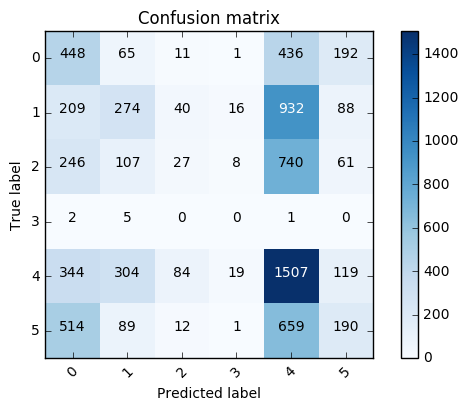

In [44]:
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_ds),
                      title='Confusion matrix')

In [45]:
print("Accuracy: ", sum(cnf_matrix.diagonal())/sum(sum(cnf_matrix)))

Accuracy:  0.315572184234


## Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
clf = RandomForestClassifier(n_estimators=20)
values = cross_val_score(clf, X_n, y_pc, cv=10)
print('Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))

Mean Accuracy : 0.374690101275 	STD:  0.00542697475853


#### RandomForestClassifier (n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

## NO TOCAR LAS 3 CELDAS SIGUIENTES! 

In [46]:
estimators_range = np.arange(50, 1050, 50)
criterion_range = ["gini", "entropy"] 
#max_features_range = ["auto", "log2", len(X_pc.columns)]
param_grid = {"n_estimators": estimators_range, "criterion": criterion_range, 
              }#"max_features":max_depth_range}

In [47]:
grid = GridSearchCV(RandomForestClassifier(), param_grid)

In [48]:
grid.fit(X_tr, y_tr)
print("The best classifier is: ", grid.best_estimator_)

The best classifier is:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [48]:
clf = RandomForestClassifier( criterion='entropy',n_estimators=600)
values = cross_val_score(clf, X_n, y_pc, cv=10)
print('Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))

Mean Accuracy : 0.415517095058 	STD:  0.00849110404437


In [49]:
clf.fit(X_tr, y_tr)
clf.score(X_te, y_te)

0.40897948651786864

In [50]:
y_hat = clf.predict(X_te)
cnf_matrix = confusion_matrix(y_te, y_hat)

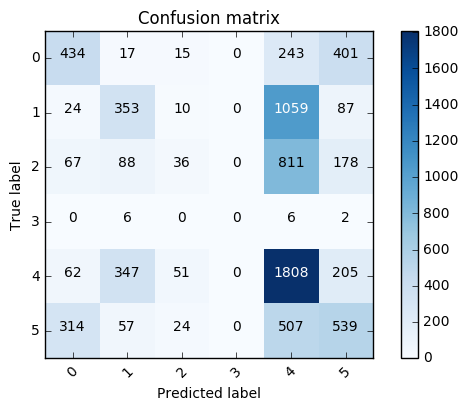

In [51]:
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_pc),
                      title='Confusion matrix')

In [52]:
print("Accuracy: ", sum(cnf_matrix.diagonal())/sum(sum(cnf_matrix)))

Accuracy:  0.408979486518
